In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#PDFs in BDT and sindec?
import os

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
os.environ['MKL_NUM_THREADS'] = "1"
os.environ['NUMEXPR_NUM_THREADS'] = "1"
os.environ['OMP_NUM_THREADS'] = "1"
os.environ['OPENBLAS_NUM_THREADS'] = "1"
os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import csky as cy
from csky import cext
import numpy as np
import pandas as pd
import astropy
#from icecube import astro
import histlite as hl
import healpy
import socket
import pickle
import copy
healpy.disable_warnings()
plt.rc('figure', facecolor = 'w')
plt.rc('figure', dpi=100)

## Define Settings

In [2]:
selection_version = 'version-001-p00'

host_name = socket.gethostname()

if 'cobalt' in host_name:
    print('Working on Cobalts')
    data_prefix = '/data/user/ssclafani/data/cscd/final'
    ana_dir = '/data/user/ssclafani/data/analyses/'
    plot_dir = '/home/mhuennefeld/public_html/analyses/DNNCascade/plots/review/bkg_ts_flucuations'
    
elif 'phobos' in host_name:
    print('Working on Phobos')
    data_prefix = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/data/cscd/final'
    ana_dir = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/csky/analyses/'
    plot_dir = '/home/mhuennefeld/analyses/DNNCascade/plots/review/bkg_ts_flucuations'
    
else:
    raise ValueError('Unknown host:', host_name)

Working on Cobalts


In [3]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

## Load Data

In [4]:
repo = cy.selections.Repository()
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr

In [5]:
class DNNCascade_10yr_mc_weights(cy.selections.DNNCascadeDataSpecs.DNNCascade_10yr):
    def dataset_modifications(self, ds):
        print('Adding weights to MC')
        path_sig_df = (
            '/data/ana/PointSource/DNNCascade/analysis/' + 
            self._path_sig.format(version=self._version).replace('dnn_cascades/', '').replace('.npy', '.hdf')
        )
        df = pd.read_hdf(path_sig_df, key='df')
        assert np.allclose(df['run'], ds.sig.run)
        assert np.allclose(df['energy'], ds.sig.energy)
        assert np.allclose(df['ow'], ds.sig.oneweight)
        for k in df.keys():
            if 'weight' in k or 'veto' in k:
                ds.sig[k] = df[k]

specs = [DNNCascade_10yr_mc_weights]

In [6]:
%%time

ana = cy.get_analysis(
    repo, selection_version, specs, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
DNNCascade_10yr_mc_weights
Setting up DNNCascade_10yr_mc_weights...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/ve

In [7]:
a = ana.anas[0]
a.sig

Events(398873 items | columns: azimuth, dec, energy, event, log10energy, mjd, nuveto_pf_dnn_cascade_selection_H3a_SIBYLL2_3c_conv, nuveto_pf_dnn_cascade_selection_H3a_SIBYLL2_3c_pr, nuveto_pf_dnn_cascade_selection_H3a_SIBYLL2_3c_total, ra, run, sigma, sindec, subevent, weights, weights_MCEq_H3a_sibyll2_3c_conv, weights_MCEq_H3a_sibyll2_3c_pr, weights_MCEq_H3a_sibyll2_3c_total, weights_aachen_flux, weights_aachen_flux_8yr, weights_cscd_hans, weights_cscd_icrc15, weights_global_fit, weights_hese4_bestfit, weights_hese4_fixed, weights_hese6, weights_hese_flux, weights_livetime, weights_mese_flux, weights_meta_info_n_events_per_run, weights_meta_info_n_files, xdec, xra, true_dec, true_energy, true_ra, oneweight)

In [8]:
a.bg_data

Events(59610 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent)

## Helper Functions

In [103]:
from cycler import cycle
from copy import deepcopy

soft_colors = cy.plotting.soft_colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def get_color_cycler():
    return cycle(colors)

def get_toy_exp_data(seed, livetime, df):
    df = deepcopy(df)
    rng = np.random.RandomState(seed)
    
    assert np.allclose(df.weights_livetime, df.weights_livetime[0])
    
    n_events = np.sum(df.weights * livetime / df.weights_livetime[0])
    print('Sampling from Poisson with: {} events'.format(n_events))
    
    p = df.weights / np.sum(df.weights)
    idx = np.random.choice(range(len(df)), size=rng.poisson(n_events), replace=True, p=p)
    
    toy_data = df[idx]
    return toy_data

def get_toy_ana(livetime, seed):
    """Get ana toy dataset"""
    class DNNCascade_10yr_mod(cy.selections.DNNCascadeDataSpecs.DNNCascade_10yr):
        def dataset_modifications(self, ds):
            sig = copy.deepcopy(ds.sig)
            data = copy.deepcopy(ds.data)
            ds.data = get_toy_exp_data(seed=seed, livetime=livetime, df=a.sig)

    specs = [DNNCascade_10yr_mod]
    repo = cy.selections.Repository()
    ana_mod = cy.get_analysis(repo, selection_version, specs)
    return ana_mod
    

def get_trial_runner(sindec, gamma, ana, cpus, ra=0., cutoff_TeV=np.inf, sigsub=True):
    src = cy.utils.sources(ra, np.arcsin(sindec), deg=False)
    cutoff_GeV = cutoff_TeV * 1e3
    conf = {
        'src' : src, 
        'flux' : cy.hyp.PowerLawFlux(gamma, energy_cutoff = cutoff_GeV),
        'update_bg': True,
        'sigsub' :  sigsub,
        'randomize' : ['ra', cy.inj.DecRandomizer],
        'sindec_bandwidth' : np.radians(5),
        'dec_rand_method' : 'gaussian_fixed',
        'dec_rand_kwargs' : dict(randomization_width = np.radians(3)),
        'dec_rand_pole_exlusion' : np.radians(8)
    }
    tr = cy.get_trial_runner(ana=ana, conf= conf, mp_cpus=cpus)
    return tr, src

def get_trial_runner_no_sigsub(*args, **kwargs):
    if 'sigsub' in kwargs: raise KeyError('sigsub is defined!')
    return get_trial_runner(*args, sigsub=False, **kwargs)

def get_bkg_trials(sindec, gamma, ana, cpus=20, sigsub=True, cutoff_TeV=np.inf, n_trials=10000):
    
    # get trial runner
    trial_runner, src = get_trial_runner(
        sindec, ra=0., gamma=gamma, ana=ana, sigsub=sigsub, cpus=cpus, cutoff_TeV=cutoff_TeV)
    
    # get background trials
    print('Performing BG Trials at RA: {}, DEC: {}'.format(src.ra_deg, src.dec_deg))
    bg = cy.dists.Chi2TSD(trial_runner.get_many_fits(n_trials=n_trials, cpus=cpus))
    
    return bg

def run_toy_trials(livetime, seed, **kwargs):
    """Run bkg trials with a toy MC as background"""
    # get analysis
    ana_mod = get_toy_ana(livetime=livetime, seed=seed)
    
    # get trial runner and run bkg trials
    bg = get_bkg_trials(ana=ana_mod, **kwargs)
    
    return bg

def plot_bkg_trials(
            bg, fig=None, ax=None, 
            label='{} bg trials', 
            label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$', 
            color=colors[0],
            bins=50,
        ):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    h = bg.get_hist(bins=bins)
    if label is not None:
        label = label.format(bg.n_total)
    hl.plot1d(ax, h, crosses=True, color=color, label=label)

    # compare with the chi2 fit:
    x = h.centers[0]
    norm = h.integrate().values
    if label_fit is not None:
        label_fit = label_fit.format(bg.ndof, bg.eta)
    ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)

    ax.set_xlabel(r'TS')
    ax.set_ylabel(r'number of trials')
    ax.legend()
        
    return fig, ax

def plot_bkg_trials_range(
            bgs, fig=None, ax=None, 
            label='{} bg trials', 
            label_fit_median=r'$\chi^2[{:.2f}$ dof $\eta={:.3f}]$ | Median', 
            label_fit=r'$\chi^2[{:.2f}$ dof $\eta={:.3f}]$ | Sample {}', 
            color=colors[0],
            bins=np.linspace(0, 20, 50),
        ):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    total_bg = bgs[0]
    for bg in bgs[1:]:
        total_bg += bg
    hs = [bg.get_hist(bins=bins) for bg in bgs]
    if label is not None:
        label = label.format(bgs[0].n_total)
    
    # get median values
    hs_values = np.array([h.values for h in hs])
    h_median = hl.Hist(bins=bins, values=np.median(hs_values, axis=0))
    h_min = hl.Hist(bins=bins, values=np.min(hs_values, axis=0))
    h_max = hl.Hist(bins=bins, values=np.max(hs_values, axis=0))
    
    # plot range
    hl.fill_between(ax, h_min, h_max, color=color, alpha=.3, drawstyle='line')
    hl.plot1d (ax, h_median, color=color, lw=2, drawstyle='default')
    
    if label is not None:
        label = label.format(bg.n_total)
    hl.plot1d(ax, h_median, crosses=True, color=color, label=label)
    
    # chi2 fit for median hist:
    x = h_median.centers[0]
    norm = h_median.integrate().values
    if label_fit_median is not None:
        label_fit_median = label_fit_median.format(total_bg.ndof, total_bg.eta)
    ax.semilogy(x, norm * total_bg.pdf(x), lw=1, ls='--', label=label_fit_median, color=color)
    
    # compare with the chi2 fit:
    for i, (h, bg) in enumerate(zip(hs, bgs)):
        x = h.centers[0]
        norm = h.integrate().values
        if label_fit is not None:
            label_fit_i = label_fit.format(bg.ndof, bg.eta, i)
        ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', label=label_fit_i, color=color, alpha=0.3)

    ax.set_xlabel(r'TS')
    ax.set_ylabel(r'number of trials')
    ax.legend()
        
    return fig, ax


## Run Background Trials

In [107]:
sindecs = [-0.8, -0.4, 0.0, 0.4, 0.8]
#sindecs = [-0.4]
cpus = 20
gamma = 2.5
n_trials = 100000


#### Exp Data

In [108]:
trials_dict_exp = {}

for sindec in sindecs:
    for i in range(1):
        bg = get_bkg_trials(sindec, gamma, ana, cpus=cpus, sigsub=True, cutoff_TeV=np.inf, n_trials=n_trials)
        
        # save data
        trials_dict_exp[(sindec, i)] = bg

        with open(os.path.join(plot_dir, 'trials_exp.pkl'), 'wb') as f:
            pickle.dump(trials_dict_exp, f, protocol=2)
            

Performing BG Trials at RA: [0.], DEC: [-53.13010235]
Performing 100000 background trials using 20 cores:
     100000/100000 trials complete.   
Performing BG Trials at RA: [0.], DEC: [-23.57817848]
Performing 100000 background trials using 20 cores:
     100000/100000 trials complete.   
Performing BG Trials at RA: [0.], DEC: [0.]
Performing 100000 background trials using 20 cores:
     100000/100000 trials complete.   
Performing BG Trials at RA: [0.], DEC: [23.57817848]
Performing 100000 background trials using 20 cores:
     100000/100000 trials complete.   
Performing BG Trials at RA: [0.], DEC: [53.13010235]
Performing 100000 background trials using 20 cores:
     100000/100000 trials complete.   


#### MC background

In [114]:
trials_dict_mc = {}

for sindec in sindecs:
    for i in range(1):
        
        # create unique random seed for each trial
        seed = int((1+sindec) * 100) + i * 10000
        print('sindec: {:3.2f} | Iteration: {} | seed'.format(sindec, i, seed))
        
        # run trials
        bg = run_toy_trials(seed=seed, livetime=a.livetime * 10, sindec=sindec, gamma=gamma, cpus=10, n_trials=n_trials)
        
        # save data
        trials_dict_mc[(sindec, i)] = bg

        with open(os.path.join(plot_dir, 'trials_mc.pkl'), 'wb') as f:
            pickle.dump(trials_dict_mc, f, protocol=2)

sindec: -0.80 | Iteration: 0 | seed
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/an

NameError: name 'fasdfa' is not defined

In [115]:
np.rad2deg(0.08726646259971647)

5.0

#### Toy exp sets

In [109]:
trials_dict = {}

for sindec in sindecs:
    for i in range(10):
        
        # create unique random seed for each trial
        seed = int((1+sindec) * 100) + i * 10000
        print('sindec: {:3.2f} | Iteration: {} | seed'.format(sindec, i, seed))
        
        # run trials
        bg = run_toy_trials(seed=seed, livetime=a.livetime, sindec=sindec, gamma=gamma, cpus=cpus, n_trials=n_trials)
        
        # save data
        trials_dict[(sindec, i)] = bg

        with open(os.path.join(plot_dir, 'trials.pkl'), 'wb') as f:
            pickle.dump(trials_dict, f, protocol=2)

sindec: -0.80 | Iteration: 0 | seed
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/an

  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-53.13010235]
Performing 100000 background trials using 20 cores:
     100000/100000 trials complete.   
sindec: -0.80 | Iteration: 4 | seed
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-53.13010235]
Performing 100000 background trials using 20 cores:
     100000/100000 trials complete.   
sindec: -0.80 | Iteration: 8 | seed
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyse

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-23.57817848]
Performing 100000 background trials using 20 cores:
     100000/100000 trials complete.   
sindec: -0.40 | Iteration: 2 | seed
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-23.57817848]
Performing 100000 background trials using 20 cores:
     100000/100000 trials complete.   
sindec: -0.40 | Iteration: 6 | seed
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-23.57817848]
Performing 100000 background trials using 20 cores:
     100000/100000 trials complete.   
sindec: 0.00 | Iteration: 0 | seed
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [0.]
Performing 100000 background trials using 20 cores:
     100

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...


Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/d

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_casca

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/vers

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/

## Load Trials

In [112]:
with open(os.path.join(plot_dir, 'trials_exp.pkl'), 'rb') as f:
    trials_dict_exp = pickle.load(f)
    
with open(os.path.join(plot_dir, 'trials_mc.pkl'), 'rb') as f:
    trials_dict_mc = pickle.load(f)
    
with open(os.path.join(plot_dir, 'trials.pkl'), 'rb') as f:
    trials_dict = pickle.load(f)
    

## Make Plots

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib

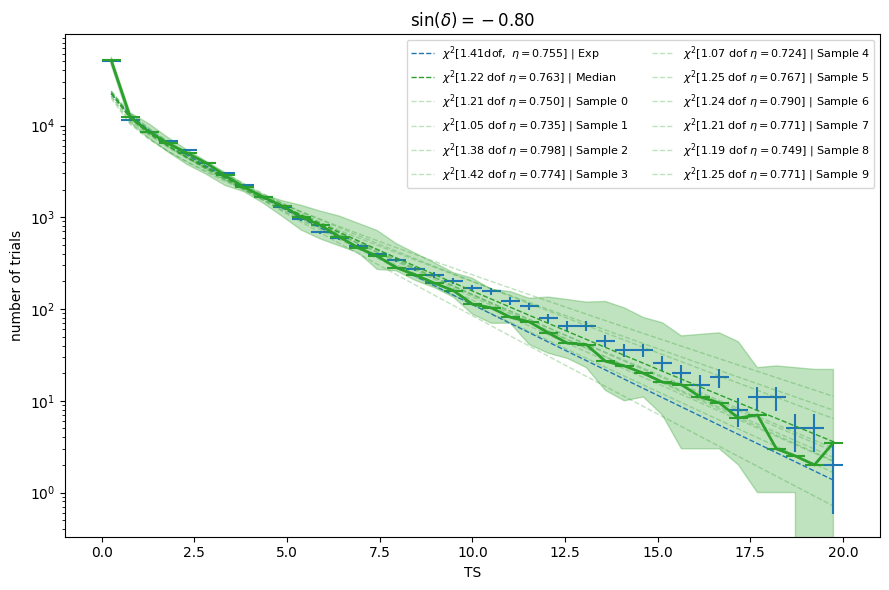

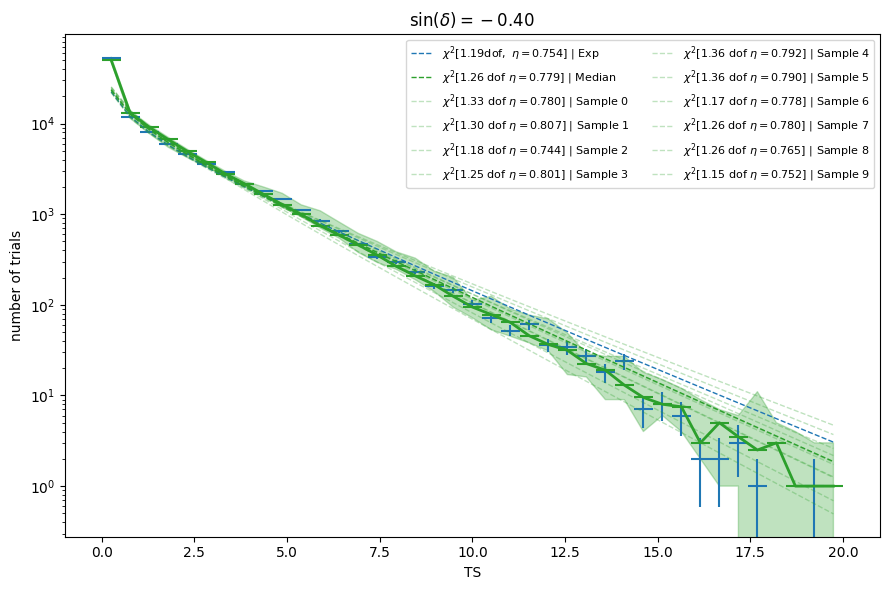

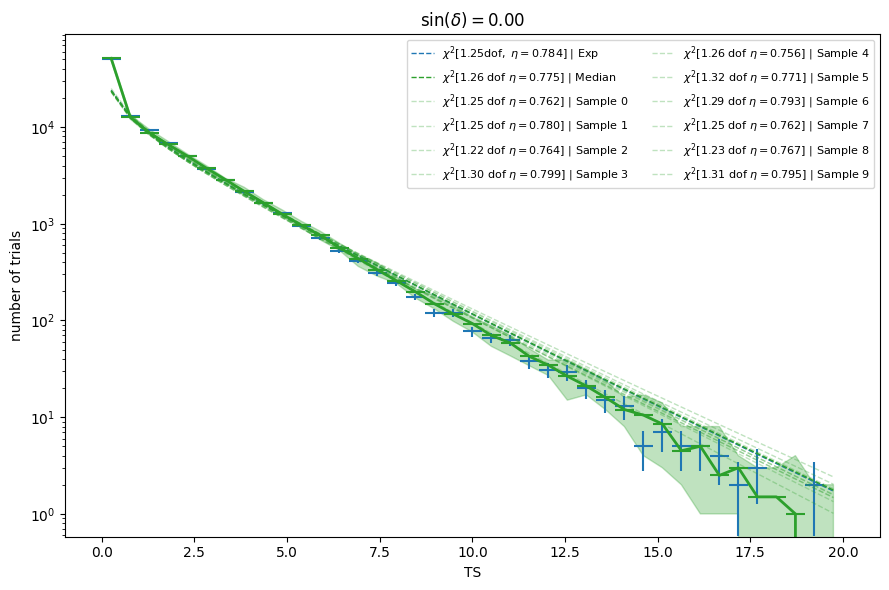

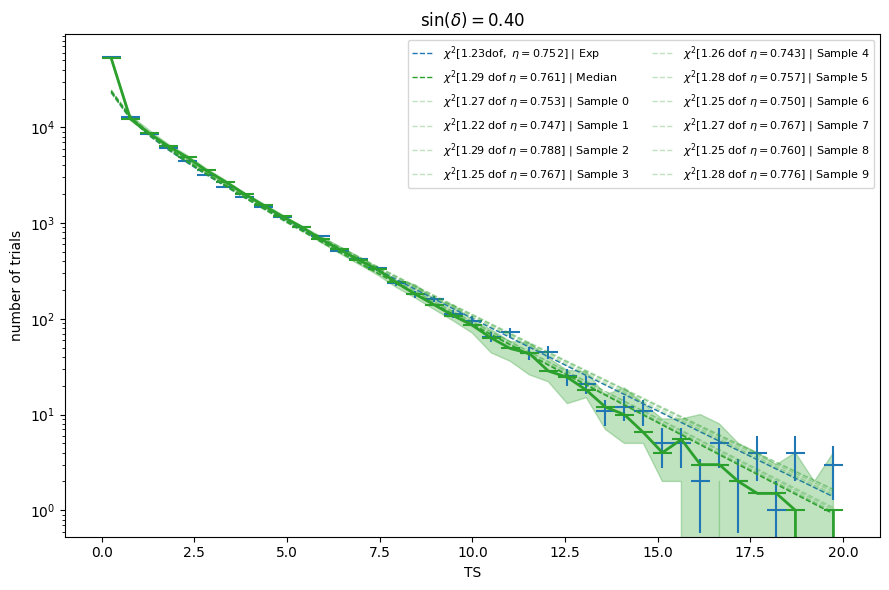

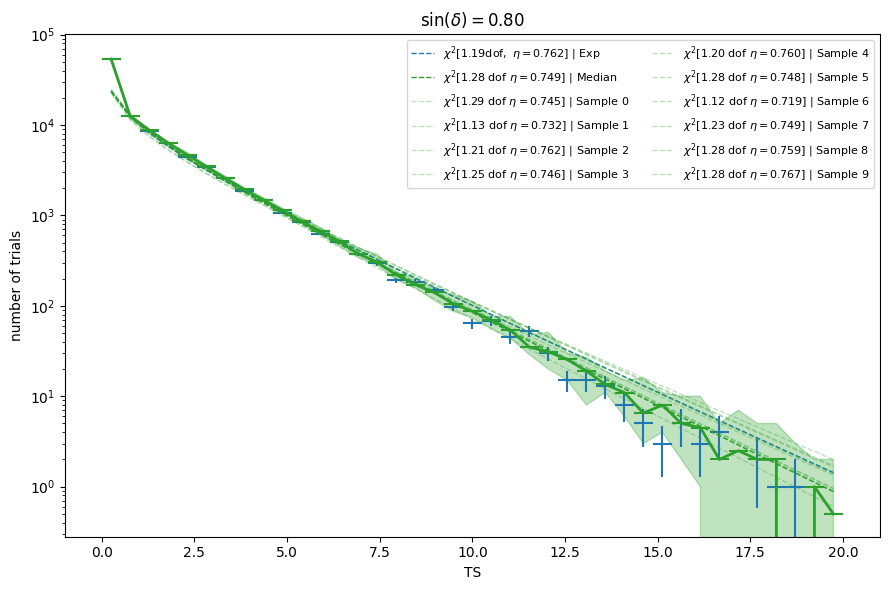

In [113]:
bins = np.linspace(0, 20, 40)
for sindec in sindecs:
    fig, ax = plt.subplots(figsize=(9, 6))
    
    # plot exp TS distribution
    plot_bkg_trials(
        trials_dict_exp[(sindec, 0)], color=colors[0], fig=fig, ax=ax, bins=bins, 
        label=None, label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$ | Exp',
    )
    
    # plot MC TS distribution
    if (sindec, 0) in trials_dict_mc:
        plot_bkg_trials(
            trials_dict_mc[(sindec, 0)], color=colors[1], fig=fig, ax=ax, bins=bins, 
            label=None, label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$ | MC [10x livetime]',
        )
    
    bgs = []
    for key, bg in trials_dict.items():
        if key[0] != sindec: continue
        bgs.append(bg)
        #plot_bkg_trials(bg, color='k', fig=fig, ax=ax, bins=bins, label=None)
    plot_bkg_trials_range(bgs=bgs, fig=fig, ax=ax, bins=bins, color=colors[2], label=None)
    
    ax.set_title(r'$\sin(\delta)={:3.2f}$'.format(sindec))
    ax.legend(fontsize=8, loc='upper right', ncol=2)
    
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir, 'bkg_ts_fluctuations_sindec_{:3.2f}.png'.format(sindec)))    
            